# IMDB

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

## Exploration and Preparing (Sample)

In [3]:
# Pull data

path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/imdb_sample/data_save.pkl'),
 PosixPath('/home/jupyter/.fastai/data/imdb_sample/texts.csv')]

In [4]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [5]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

In [6]:
data = TextClasDataBunch.from_csv(path, 'texts.csv')
data.show_batch()

text,target
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first stealth games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - xxunk gaming experience in general . xxmaj with graphics",positive
"xxbos i really wanted to love this show . i truly , honestly did . \n \n xxmaj for the first time , gay viewers get their own version of the "" xxmaj the xxmaj bachelor "" . xxmaj with the help of his obligatory "" hag "" xxmaj xxunk , xxmaj james , a good looking , well - to - do thirty - something has the chance",negative
"xxbos \n \n i 'm sure things did n't exactly go the same way in the real life of xxmaj homer xxmaj hickam as they did in the film adaptation of his book , xxmaj rocket xxmaj boys , but the movie "" xxmaj october xxmaj sky "" ( an xxunk of the book 's title ) is good enough to stand alone . i have not read xxmaj",positive
"xxbos xxmaj to review this movie , i without any doubt would have to quote that memorable scene in xxmaj tarantino 's "" xxmaj pulp xxmaj fiction "" ( xxunk ) when xxmaj jules and xxmaj vincent are talking about xxmaj mia xxmaj wallace and what she does for a living . xxmaj jules tells xxmaj vincent that the "" xxmaj only thing she did worthwhile was pilot "" .",negative


In [7]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

### Numericalization
The first step of processing we make the texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at least twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids to tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

In [8]:
data.train_ds[0][0]

Text xxbos xxmaj first of all i thought it was naughty of them to say in the credits that the story and screenplay were by xxmaj preston xxmaj sturges . xxmaj sturges was one of the better xxmaj hollywood screenwriters until his talent xxunk and he retired . xxmaj however , it was n't the xxmaj preston xxmaj sturges , it was xxmaj preston xxmaj sturges , xxmaj jr. xxmaj the story was essentially based on xxmaj robert xxmaj louis xxmaj stevenson 's short story " xxmaj the xxmaj bottle xxmaj xxunk " . a good man comes into possession of an evil object that will grant him any wish but which will ultimately doom him to hell . xxmaj that 's fine . xxmaj nobody said screenwriters had to be original . xxmaj the actors are generally pretty competent given the mediocre writing that they had to translate onto the screen . xxmaj my biggest complaint comes with the ending . xxmaj the hero thinks he has discovered a way out of his dilemma but tries to solve the problem in a somewhat different way i

In [9]:
# But the underlying data is all numbers
data.train_ds[0][0].data[:10]

array([   2,    5,  101,   14,   46,   19,  218,   17,   25, 4482])

### With the data block API
We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the various arguments to pass will appear in the step they're revelant, so it'll be more readable.

In [ ]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

### (Full dataset) Tokenization

In [10]:
# Pull data

path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/imdb/README'),
 PosixPath('/home/jupyter/.fastai/data/imdb/models'),
 PosixPath('/home/jupyter/.fastai/data/imdb/unsup'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train'),
 PosixPath('/home/jupyter/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/jupyter/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/jupyter/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/jupyter/.fastai/data/imdb/data_lm.pkl'),
 PosixPath('/home/jupyter/.fastai/data/imdb/test')]

In [11]:
## Language model
bs=16
# reduce if it takes a lot of memory

We have to use a special kind of TextDataBunch for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.


In [12]:
# Tokenize and numericalize text data
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

In [13]:
# For loading the notebook after save
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [14]:
data_lm.show_batch()

idx,text
0,"is wooden as xxmaj adam , although xxmaj chriqui is very convincing as xxmaj eve . xxmaj the frat - house shenanigans are tame beyond belief when compared to other xxmaj lampoon college movies , and the girl waiting for the perfect time to toss in her v - card is an old theme that is n't xxunk in any way by this film . xxmaj after great xxmaj national"
1,"most powerful , highly distinctive drama . xxbos i am a major horror film buff , but this was one of the worst films i have ever seen . xxmaj typical of "" xxmaj special xxmaj effects "" movie , the story line suffered ( or should i say , "" xxmaj what story line xxrep 4 ? "") xxmaj the gore was n't even cool gore , just lame"
2,"all agree that constitutional rights need to be protected but , at the end of the day , this movie is just another sappy , preachy xxmaj spielberg movie . ( xxmaj and why is it everyone in the future has a hovercraft ? xxmaj even more importantly , when do i get my own hovercraft ? ) xxbos xxmaj wow . xxmaj this movie was xxup horrible . xxmaj"
3,"it . xxmaj she 's so pathetic , she 'll stalk her neighbor , but she suddenly has too much pride to be nice to the one co - worker who is trying to be friends with her ? xxmaj too full of pride to even be honest with her own mother as to the troubles she 's having ? xxmaj and that ending- xxmaj call me stupid , but"
4,". xxmaj inexorably , the pieces of his soul meet ( on either side of the opening to the trunk ) and unify . xxmaj trevor 's torment , and the film , abruptly resolve . xxmaj his painful dreams evaporate and he regains his earthly existence . xxbos xxmaj henry xxmaj hathaway made so many and such a variety of films , that when he did something outstanding like"


In [15]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [16]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


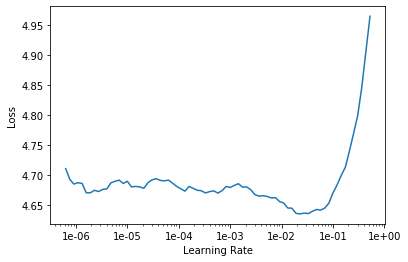

In [17]:
learn.recorder.plot(skip_end=15)

In [18]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.503525,4.291763,0.281599,1:35:43


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [19]:
learn.save('fit_head')

In [20]:
learn.load('fit_head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (90000 items)
x: LMTextList
xxbos xxmaj if you check the other comments , you 'll hear about this being a great romantic comedy . xxmaj it 's not . xxmaj as a romantic comedy , it barely passes muster . xxmaj the laughs are few and far between , the plot is completely formulaic , and the only thing " xxmaj national xxmaj lampoon " about this film is the title . xxmaj douglas is wooden as xxmaj adam , although xxmaj chriqui is very convincing as xxmaj eve . xxmaj the frat - house shenanigans are tame beyond belief when compared to other xxmaj lampoon college movies , and the girl waiting for the perfect time to toss in her v - card is an old theme that is n't xxunk in any way by this film . xxmaj after great xxmaj national xxmaj lampoon titles like " xxmaj van xxmaj wilder " , " xxmaj animal xxmaj house " , and the " xxmaj vacation " movies , this one feels like the first attempt of someone straight out of film school .,xxbos xxmaj

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
learn.save('fine_tuned')

In [ ]:
learn.load('fine_tuned')

In [ ]:
learn.predict("I liked this movie because ", 100, temperature=1.1, min_p=0.001)

In [ ]:
learn.save('fine_tuned_enc')

# Classifier

In [ ]:
data_clas = (TextFilesList.from_folder(path, vocab=data_lm.vocab)
             .split_by_folder(valid="test")
             .label_from_encoder(classes=['neg','pos'])
             .databunch(bs=50))
data_clas.save('tmp_clas')

In [ ]:
data_clas = TextClasDataBunch.load(path, 'tmp_clas', bs=50)
data_clas.show_batch()

In [ ]:
learn = text_classifier_learner(data_clas, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')
learn.freeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
# learn.fit_one_cycle(1, )